In [125]:
import torch
import unicodedata
import torch.nn as nn 
import matplotlib.pyplot as plt 
from IPython.display import Image
import io
import os
import string
import glob
import torch
import random

## Some functions to work on files and strings

##### parametr

In [126]:
CHARACTER = string.ascii_letters + ' ' + '.' + ',' + ';' + "'"
Len_Character = len(CHARACTER)
hid_len = 200
Alph = 0.005
current_loss = 0
Collection_of_losses = []
num = 120000
local_loss = 0
CHARACTER

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [127]:
def cnvrt_acti(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in CHARACTER
    )

In [128]:
def LoadData():
    Country_dict = {};All_Country = []

    def find_files(path):
        return glob.glob(path)

    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [cnvrt_acti(line) for line in lines]

    for filename in find_files('*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        All_Country.append(category)
        lines = read_lines(filename)
        Country_dict[category] = lines
        
    return Country_dict, All_Country

In [129]:
def FindInex(letter):
    return CHARACTER.find(letter)

## One Hot Encoding

In [130]:
def oneHot_tensor(line):
    tensor = torch.zeros(len(line), 1, Len_Character)
    for i, letter in enumerate(line):
        tensor[i][0][FindInex(letter)] = 1
    return tensor

In [131]:
def Random(Country_dict, All_Country):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(All_Country)
    line = random_choice(Country_dict[category])
    category_tensor = torch.tensor([All_Country.index(category)], dtype=torch.long)
    line_tensor = oneHot_tensor(line)
    return category, line, category_tensor, line_tensor

# RNN

In [132]:
class RNN(nn.Module):
    def __init__(self, inp_len, hid_len, out_len):
        super(RNN, self).__init__()
        
        self.hid_len = hid_len
        self.i2h = nn.Linear(inp_len + hid_len, hid_len)
        self.i2o = nn.Linear(inp_len + hid_len, out_len)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        
        combined = torch.hstack((input_tensor, hidden_tensor))
        hidden = self.i2h(combined)
        out = self.softmax(self.i2o(combined))
        
        return out, hidden
    
    def CrtZero(self):
        return torch.zeros(1, self.hid_len)

In [133]:
Country_dict, All_Country = LoadData()
All_Country

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [134]:
Sample = RNN(Len_Character, hid_len, len(All_Country))

In [135]:
def GetResult(output):
    category_idx = torch.argmax(output).item()
    return All_Country[category_idx]

In [136]:
detriment = nn.NLLLoss()
optimizer = torch.optim.SGD(Sample.parameters(), lr=Alph)

In [137]:
def TrainingModel(line_tensor, category_tensor):

    hidden = Sample.CrtZero()
    for i in range(line_tensor.size()[0]):
        output, hidden = Sample(line_tensor[i], hidden)
        
    ls = detriment(output, category_tensor)
    ls.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    return output, ls.item()

In [138]:

for i in range(num):

    country, line, category_tensor, line_tensor = Random(Country_dict, All_Country)
    prd, loss = TrainingModel(line_tensor, category_tensor)
    
    local_loss += loss 
    
    if (i+1) % 5000 == 0:

        Collection_of_losses.append(local_loss / 1000)
        local_loss = 0
        
    if (i+1) % 6000 == 0:
        guess = GetResult(prd)

        if guess == country:
            correct = "Correct Answer."
        else:
            correct = "Wrong Answer!!"  

        print(i , '. ' , "loss = " , f"{loss:.4f}   {line} - {guess} , {correct}")

5999 .  loss =  3.3915   Opp - Chinese , Wrong Answer!!
11999 .  loss =  2.5599   Laberenz - Spanish , Wrong Answer!!
17999 .  loss =  0.3803   Bertolini - Italian , Correct Answer.
23999 .  loss =  0.0807   Avgerinos - Greek , Correct Answer.
29999 .  loss =  1.8473   Santos - Greek , Wrong Answer!!
35999 .  loss =  1.8602   Obando - Italian , Wrong Answer!!
41999 .  loss =  1.3618   Olivier - French , Correct Answer.
47999 .  loss =  5.0099   Tourna - Spanish , Wrong Answer!!
53999 .  loss =  2.0855   Denby - Czech , Wrong Answer!!
59999 .  loss =  0.5491   So - Korean , Correct Answer.
65999 .  loss =  2.1389   Carbone - French , Wrong Answer!!
71999 .  loss =  1.7130   Isa - Japanese , Wrong Answer!!
77999 .  loss =  0.2182   Zientek - Polish , Correct Answer.
83999 .  loss =  0.0698   Kaczka - Polish , Correct Answer.
89999 .  loss =  0.3025   Cnaimhin - Irish , Correct Answer.
95999 .  loss =  3.9460   Sappe - Dutch , Wrong Answer!!
101999 .  loss =  1.0950   Clark - Scottish , C

### Draw diagram


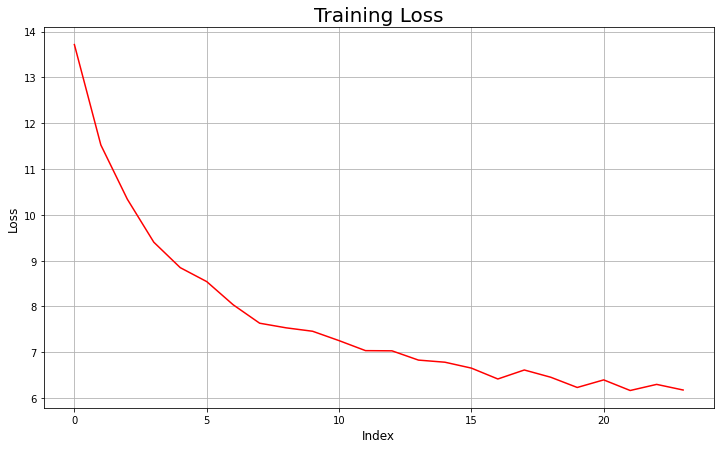

In [139]:
plt.figure(figsize=(12, 7))
plt.plot(Collection_of_losses, color='red')
plt.title('Training Loss', fontsize=20)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()

In [141]:
while True:
    ph = input("Do you want to continue or is it over? If you want to continue, enter Yes, otherwise it will end = ")
    if ph=="Yes":
        with torch.no_grad():
            input_line = input("Input Name :")

            line_tensor = oneHot_tensor(input_line)
            hidden = Sample.CrtZero()
            
            for i in range(line_tensor.shape[0]):
                output, hidden = Sample(line_tensor[i], hidden)
            
            res = GetResult(output)
            print("Input ",input_line," , result :", res)
    else:
        print("Bye.")
        break

Input  Narato  , result : Japanese
Input  Zhelehovsky  , result : Russian
Input  Phi  , result : Korean
Input  Adamczak  , result : Polish
Input  Lévesque  , result : French
Input  Kalakos  , result : Greek
Bye.
